![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

Note that this research was done in quantconnect, which doesn't allow you to export research notebooks, so I have copied down the code and images into this notebook from the cloud environment. Copy and run the code cells in your own research environment to reproduce the results.

In [ ]:
import datetime as dt
from IPython.display import Image

qb = QuantBook()
qb.set_start_date(2025, 1, 2)

### Introduction

This study investigates the impact of early-session relative volume on the subsequent price range of the E-mini S&P 500 futures. Specifically, we examine whether the relative volume measured at 10 a.m. can serve as a reliable predictor of the day's overall volatility. By comparing the current session's cumulative volume against historical averages, we aim to quantify deviations in market activity that directly influence the day’s range.

Understanding this relationship is essential for traders, as it provides a data-driven framework for setting volatility targets and adjusting price levels. A higher-than-average relative volume at 10 a.m. may indicate increased market momentum, suggesting a wider trading range, while a lower reading might signal a more subdued session. These insights can help traders refine their strategies and improve risk management by tailoring their target levels to the prevailing market conditions.

### Download ES Minute Data

We retrieve minute-level historical data for the ES (E-mini S&P 500) futures contract over 10 years (2015-2025) using QuantConnect’s API. This dataset forms the basis for our analysis of volume and range metrics.

In [ ]:
start_date = datetime(2015, 1, 1)
end_date   = datetime(2025, 1, 1)

# Add the E-mini S&P 500 futures (ES)
future = qb.AddFuture(
    Futures.Indices.SP500EMini,
    resolution = Resolution.Minute,
    dataNormalizationMode = DataNormalizationMode.BackwardsPanamaCanal,
    dataMappingMode = DataMappingMode.OpenInterest,
    extendedMarketHours = True
)

# Set filter to pick contracts (0 to 90 days from front)
future.SetFilter(0, 90)

# Pull historical data
history = qb.History(TradeBar, future.Symbol, start_date, end_date)

In [ ]:
# Clean history df
df = history.copy()

df.index = df.index.droplevel(['expiry', 'symbol'])
df.index.rename('datetime', inplace=True)
df.sort_index(inplace=True)

def assign_session(timestamp):
    """
    If time >= 18:00, label as next day's session_date. Else same day.
    This is to group trading sessions from market open (6pm ET of previous day)
    to the market close (5pm ET of the current day), as that is the period
    over which range and cumulative volume will be calculated
    """
    if timestamp.time() >= dt.time(18,0):
        return (timestamp + dt.timedelta(days=1)).date()
    else:
        return timestamp.date()

# Assign session identifiers to all minute entries
df['session_date'] = df.index.map(assign_session)

# Exclude partial/holiday sessions
# Typically ~23 hours of minute bars => ~1380 bars per session
counts = df.groupby('session_date').size()
valid_sessions = counts[counts == 1380].index  # or use >= some threshold
df = df[df['session_date'].isin(valid_sessions)]

# Sort by datetime
df.sort_values(by='datetime', inplace=True)

### Compute Relative Range and Volume Metrics

We derive key metrics to compare the current session’s performance with its recent history, using multiple lookback periods (e.g., 10-day and 20-day). Specifically, we calculate:

1. **Relative Volume:**  
   - For each session, we compute the cumulative volume at every minute and then, for each lookback period, the rolling average cumulative volume (excluding the current session to avoid lookahead bias).  
   - The **relative volume** is the ratio of the current cumulative volume at a given time to its corresponding historical average, with a special focus on the 10 a.m. reading.

2. **Relative Range:**  
   - We calculate the full-session (day) range (high minus low) and the regular trading hours (RTH) range (from 9:31 a.m. to 4:00 p.m.).  
   - For each, we compute the rolling average range over previous sessions and then derive the **relative range** as the ratio of the current range to its rolling average.

**Why 10 a.m. Relative Volume?**  
We use the 10 a.m. relative volume as an indicator because by this time most early institutional activity has subsided. This measurement better reflects the day’s prevailing volatility and volume dynamics compared to pre-open readings, which may be artificially low if market participants are waiting for news. Moreover, volatility targets are typically adjusted after the market has had time to establish its direction, making 10 a.m. a reliable benchmark for setting the day’s range expectations.

In [ ]:
# List of rolling lookback periods (in sessions) to compare (e.g., 10-day and 20-day)
rolling_periods = [10, 20]

########################################
# 1) CUMULATIVE VOLUME PER SESSION
########################################
df['cum_volume'] = df.groupby('session_date')['volume'].cumsum()

########################################
# 2) PREPARE DATA FOR ROLLING AVERAGE CALCULATION
########################################
df['time'] = df.index.time

pivot_df = df.pivot(index='session_date', columns='time', values='cum_volume')

def session_time_sort(t):
    if t >= dt.time(18, 0):
        return (0, t.hour, t.minute)
    else:
        return (1, t.hour, t.minute)

sorted_cols = sorted(pivot_df.columns, key=session_time_sort)
pivot_df = pivot_df[sorted_cols]

########################################
# 3) COMPUTE ROLLING AVERAGES & RELATIVE VOLUME FOR EACH LOOKBACK PERIOD
########################################
df = df.reset_index()

for p in rolling_periods:
    rolling_mean = pivot_df.shift(1).rolling(window=p, min_periods=1).mean()
    
    rolling_mean_long = rolling_mean.reset_index().melt(
        id_vars='session_date', 
        var_name='time', 
        value_name=f'avg_cum_volume_{p}d'
    )
    
    df = df.merge(
        rolling_mean_long,
        on=['session_date','time'],
        how='left'
    )
    
    df[f'rel_volume_{p}d'] = df['cum_volume'] / df[f'avg_cum_volume_{p}d']

df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

########################################
# 4) COMPUTE DAY & RTH RANGES
########################################
session_range_day = df.groupby('session_date').agg(
    day_high=('high', 'max'),
    day_low=('low', 'min')
)

df_rth = df.between_time('09:31','16:00')
session_range_rth = df_rth.groupby('session_date').agg(
    rth_high=('high','max'),
    rth_low=('low','min')
)

df_ranges = session_range_day.join(session_range_rth, how='left')
df_ranges['day_range'] = df_ranges['day_high'] - df_ranges['day_low']
df_ranges['rth_range'] = df_ranges['rth_high'] - df_ranges['rth_low']
df_ranges.sort_index(inplace=True)

########################################
# 5) ROLLING AVERAGES FOR day_range & rth_range
########################################
for p in rolling_periods:
    df_ranges[f'day_range_{p}d_avg'] = df_ranges['day_range'].shift(1).rolling(window=p, min_periods=1).mean()
    df_ranges[f'rth_range_{p}d_avg'] = df_ranges['rth_range'].shift(1).rolling(window=p, min_periods=1).mean()

df_ranges.dropna(inplace=True)
df_ranges.drop(columns=['day_high', 'day_low', 'rth_high', 'rth_low'], inplace=True)

########################################
# 6) EXTRACT 10AM RELATIVE VOLUME FOR EACH LOOKBACK PERIOD
########################################
df_10am = df[df['time'] == dt.time(10, 0)].copy()
df_rvol_10am = df_10am[['session_date']].copy()
for p in rolling_periods:
    temp = df_10am[['session_date', f'rel_volume_{p}d']].copy()
    temp.rename(columns={f'rel_volume_{p}d': f'rel_volume_{p}d_10am'}, inplace=True)
    df_rvol_10am = df_rvol_10am.merge(temp, on='session_date', how='left')

########################################
# 7) MERGE RANGES & 10AM RVOL INTO FINAL ANALYSIS
########################################
df_analysis = df_ranges.reset_index().merge(
    df_rvol_10am,
    on='session_date',
    how='left'
)

########################################
# 8) CREATE RELATIVE RANGE COLUMNS
########################################
# Instead of 'range_ratio_{p}', we name them 'rel_day_range_{p}d' and 'rel_rth_range_{p}d'
for p in rolling_periods:
    df_analysis[f'rel_day_range_{p}d'] = df_analysis['day_range'] / df_analysis[f'day_range_{p}d_avg']
    df_analysis[f'rel_rth_range_{p}d'] = df_analysis['rth_range'] / df_analysis[f'rth_range_{p}d_avg']
    
    # Drop the average columns for cleanliness
    df_analysis.drop(columns=[f'day_range_{p}d_avg', f'rth_range_{p}d_avg'], inplace=True, errors='ignore')

df_analysis.set_index('session_date', inplace=True)

df_analysis.head()

In [ ]:
################################################
# Plot the relative volumes vs. relative ranges
################################################

for p in rolling_periods:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    
    # Left subplot: Scatter plot of relative volume vs. relative day range for lookback period p
    axes[0].scatter(df_analysis[f'rel_volume_{p}d_10am'], df_analysis[f'rel_day_range_{p}d'], 
                    alpha=0.6, color='skyblue', edgecolor='black')
    axes[0].axhline(y=1, color='red', linestyle='dashed', linewidth=2, label='Ratio = 1')
    axes[0].set_title(f'Relative Volume vs. Relative Day Range ({p}d)')
    axes[0].set_xlabel(f'Relative Volume ({p}d) at 10am')
    axes[0].set_ylabel('Relative Day Range')
    axes[0].legend()
    
    # Right subplot: Scatter plot of relative volume vs. relative RTH range for lookback period p
    axes[1].scatter(df_analysis[f'rel_volume_{p}d_10am'], df_analysis[f'rel_rth_range_{p}d'], 
                    alpha=0.6, color='skyblue', edgecolor='black')
    axes[1].axhline(y=1, color='red', linestyle='dashed', linewidth=2, label='Ratio = 1')
    axes[1].set_title(f'Relative Volume vs. Relative RTH Range ({p}d)')
    axes[1].set_xlabel(f'Relative Volume ({p}d) at 10am')
    axes[1].set_ylabel('Relative RTH Range')
    axes[1].legend()
    
    fig.suptitle(f'Scatter Plot: Relative Volume vs. Relative Range ({p}-Day Lookback)', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

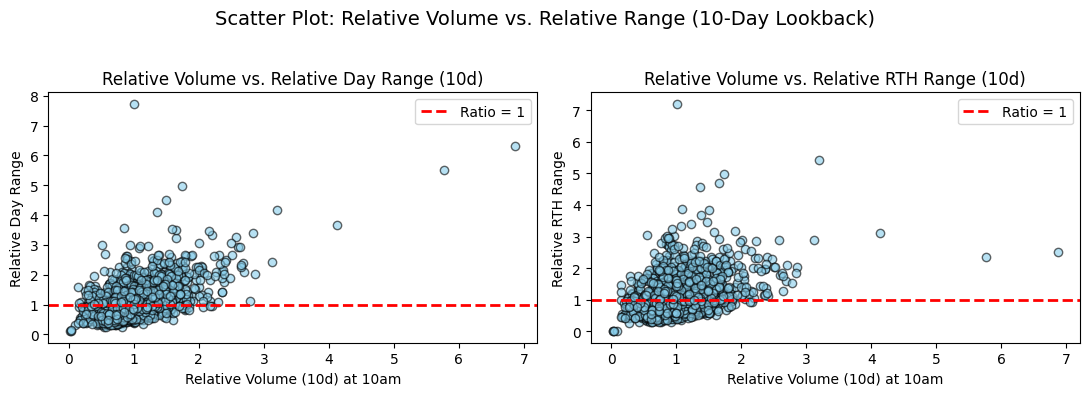

In [6]:
Image('es_volume_and_range_images/rvol_rrng_10d_scatter.png')

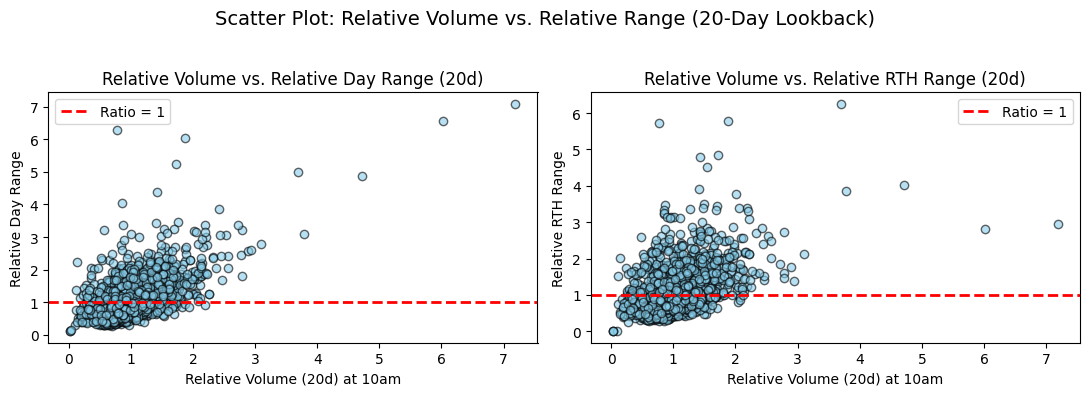

In [8]:
Image('es_volume_and_range_images/rvol_rrng_20d_scatter.png')

In [ ]:
##################################################################
# Plot the relative volumes vs. relative ranges, outliers removed
##################################################################

for p in rolling_periods:
    # Filter out outliers: only include rows where both the relative volume and both relative ranges are ≤ 4.
    filtered_df = df_analysis[
        (df_analysis[f'rel_volume_{p}d_10am'] <= 4) &
        (df_analysis[f'rel_day_range_{p}d'] <= 4) &
        (df_analysis[f'rel_rth_range_{p}d'] <= 4)
    ]
    
    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    
    # Left subplot: Scatter plot for Relative Day Range vs. Relative Volume
    axes[0].scatter(
        filtered_df[f'rel_volume_{p}d_10am'],
        filtered_df[f'rel_day_range_{p}d'],
        alpha=0.6,
        color='skyblue',
        edgecolor='black'
    )
    axes[0].axhline(y=1, color='red', linestyle='dashed', linewidth=2, label='Ratio = 1')
    axes[0].set_title(f'Rel Volume vs. Rel Day Range ({p}d Lookback)')
    axes[0].set_xlabel(f'Rel Volume ({p}d) at 10am')
    axes[0].set_ylabel('Relative Day Range')
    axes[0].legend()
    
    # Right subplot: Scatter plot for Relative RTH Range vs. Relative Volume
    axes[1].scatter(
        filtered_df[f'rel_volume_{p}d_10am'],
        filtered_df[f'rel_rth_range_{p}d'],
        alpha=0.6,
        color='skyblue',
        edgecolor='black'
    )
    axes[1].axhline(y=1, color='red', linestyle='dashed', linewidth=2, label='Ratio = 1')
    axes[1].set_title(f'Rel Volume vs. Rel RTH Range ({p}d Lookback)')
    axes[1].set_xlabel(f'Rel Volume ({p}d) at 10am')
    axes[1].set_ylabel('Relative RTH Range')
    axes[1].legend()
    
    fig.suptitle(f'Scatter Plot (Outliers Removed) for {p}-Day Lookback', fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

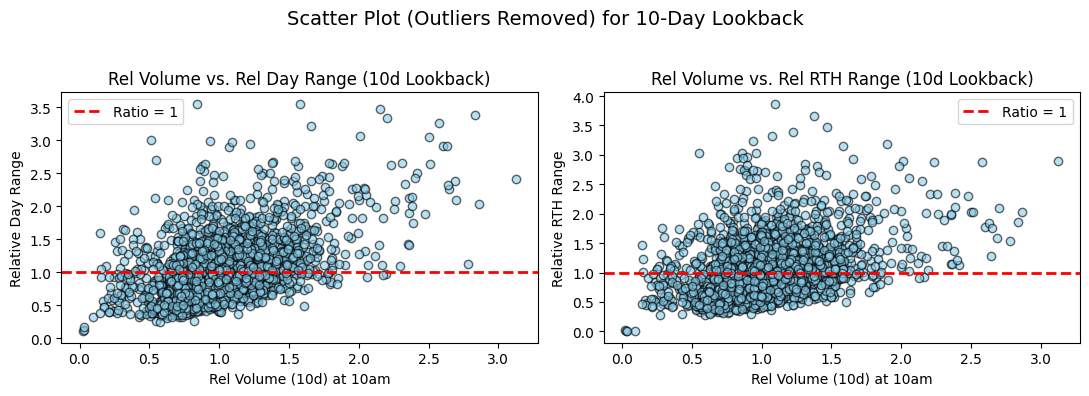

In [10]:
Image('es_volume_and_range_images/rvol_rrng_10d_scatter_nooutliers.png')

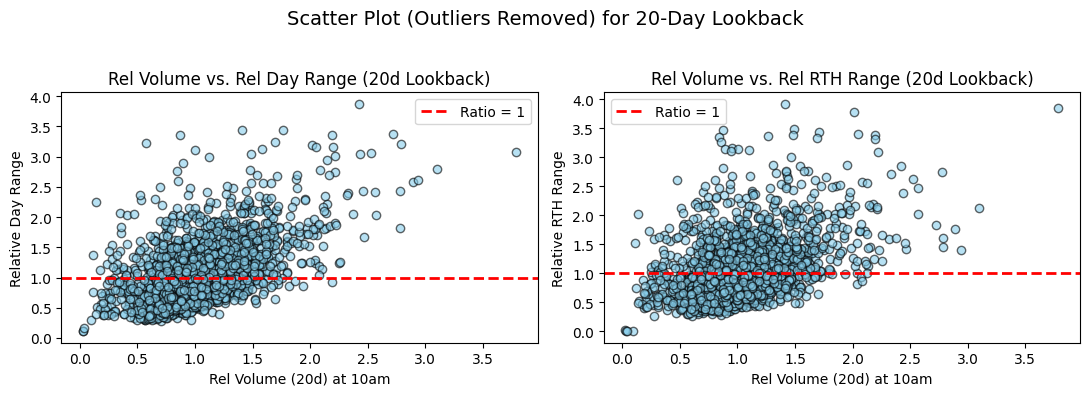

In [11]:
Image('es_volume_and_range_images/rvol_rrng_20d_scatter_nooutliers.png')

The expected positive relationship between volume and range is shown in the above plots. However it is only a mildly positive relationship and there is wide variance even at the more extreme values of both volume and range metrics. Thus, while relative volume can be used as a guide, it should not be overly relied on when target setting, as there are many instances where a high relative volume results in a low relative range and vice versa. Lets further explore the data to gain other insights about using relative volume as a tool.

In [ ]:
# Define the pairs for day range correlations
pairs_day = [
    ('rel_day_range_10d', 'rel_volume_10d_10am'),
    ('rel_day_range_20d', 'rel_volume_20d_10am'),
    ('rel_day_range_10d', 'rel_volume_20d_10am'),
    ('rel_day_range_20d', 'rel_volume_10d_10am')
]

print("Correlation for Day Range:")
for col1, col2 in pairs_day:
    corr_val = df_analysis[col1].corr(df_analysis[col2])
    print(f"{col1} vs. {col2}: {corr_val:.4f}")

# Define the pairs for RTH range correlations
pairs_rth = [
    ('rel_rth_range_10d', 'rel_volume_10d_10am'),
    ('rel_rth_range_20d', 'rel_volume_20d_10am'),
    ('rel_rth_range_10d', 'rel_volume_20d_10am'),
    ('rel_rth_range_20d', 'rel_volume_10d_10am')
]

print("\nCorrelation for RTH Range:")
for col1, col2 in pairs_rth:
    corr_val = df_analysis[col1].corr(df_analysis[col2])
    print(f"{col1} vs. {col2}: {corr_val:.4f}")

### Correlation for Day Range

| Metric Pair                                  | Correlation |
|----------------------------------------------|-------------|
| rel_day_range_10d vs. rel_volume_10d_10am     | 0.5596      |
| rel_day_range_20d vs. rel_volume_20d_10am     | 0.6129      |
| rel_day_range_10d vs. rel_volume_20d_10am     | 0.5451      |
| rel_day_range_20d vs. rel_volume_10d_10am     | 0.5450      |

### Correlation for RTH Range

| Metric Pair                                  | Correlation |
|----------------------------------------------|-------------|
| rel_rth_range_10d vs. rel_volume_10d_10am     | 0.4091      |
| rel_rth_range_20d vs. rel_volume_20d_10am     | 0.4775      |
| rel_rth_range_10d vs. rel_volume_20d_10am     | 0.3957      |
| rel_rth_range_20d vs. rel_volume_10d_10am     | 0.4149      |

The results indicate a moderately strong positive relationship between the 10 a.m. relative volume and the full-day range, with correlations ranging from about 0.55 to 0.61. In particular, the 20-day lookback appears slightly more predictive (0.6129 when both measures use a 20-day window) than the 10-day lookback for the full-day range. In contrast, for the RTH range the correlations are lower, ranging from approximately 0.39 to 0.48, suggesting that 10 a.m. relative volume is less strongly predictive of the RTH range than of the full-day range. While these correlations are statistically significant, there is still considerable unexplained variance.

The relatively lower correlations observed for RTH range are likely attributable to the influence of the preceding Globex session. When the Globex session exhibits a large range, much of the day’s total volatility is already realized, leaving less potential for additional movement during regular trading hours. In effect, a large Globex range may ‘consume’ the available range, thereby reducing the incremental impact of 10 a.m. relative volume on the RTH range.

In [ ]:
############################################
# Plot the distributions of relative ranges
############################################

for p in rolling_periods:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    
    # Left subplot: Distribution of rel_day_range_{p}d
    ax_left = axes[0]
    ax_left.hist(
        df_analysis[f'rel_day_range_{p}d'], 
        bins=50, 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7
    )
    ax_left.axvline(x=1, color='red', linestyle='dashed', linewidth=2, label='Ratio = 1')
    ax_left.set_title(f'Relative Day Range ({p}d)')
    ax_left.set_xlabel('Range')
    ax_left.set_ylabel('Frequency')
    ax_left.legend()
    
    # Right subplot: Distribution of rel_rth_range_{p}d
    ax_right = axes[1]
    ax_right.hist(
        df_analysis[f'rel_rth_range_{p}d'], 
        bins=50, 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7
    )
    ax_right.axvline(x=1, color='red', linestyle='dashed', linewidth=2, label='Ratio = 1')
    ax_right.set_title(f'Relative RTH Range ({p}d)')
    ax_right.set_xlabel('Range')
    ax_right.set_ylabel('Frequency')
    ax_right.legend()
    
    fig.suptitle(f'Distribution of Relative Day vs. RTH Ranges for {p}-Day Lookback', fontsize=14)
    fig.tight_layout()
    plt.show()

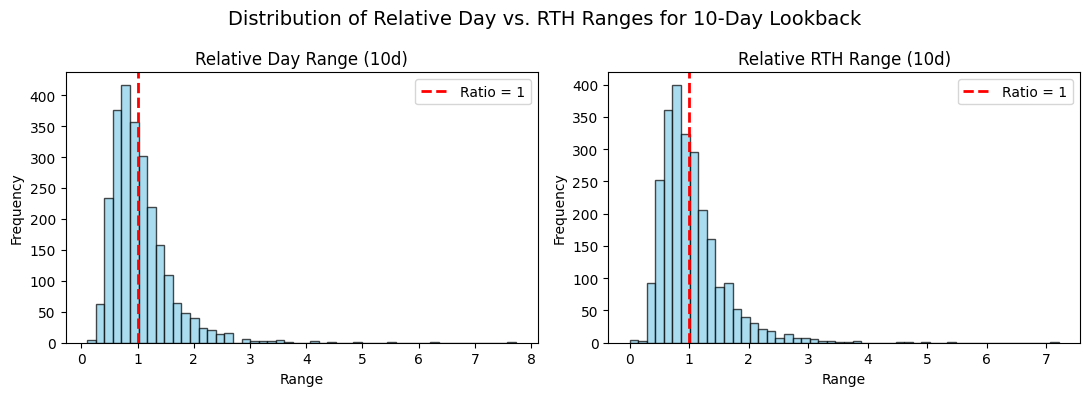

In [3]:
Image("es_volume_and_range_images/rel_rng_10d_dist.png")

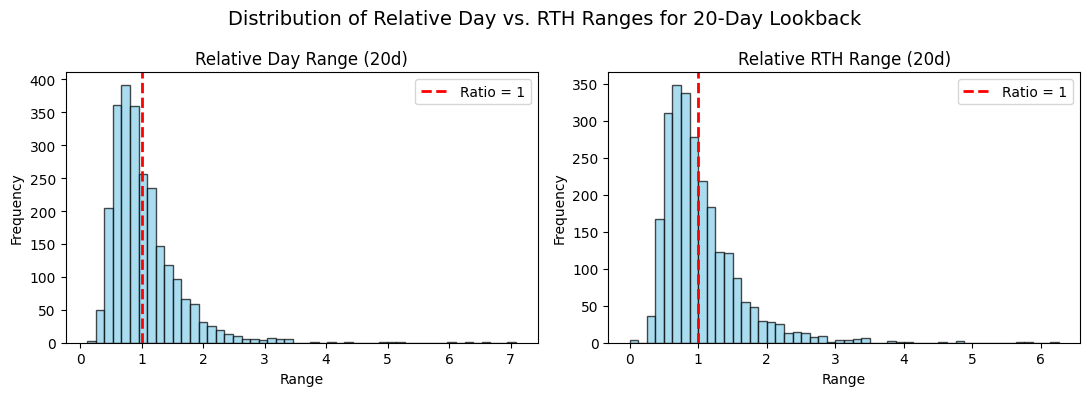

In [5]:
Image("es_volume_and_range_images/rel_rng_20d_dist.png")

The distributions of the relative RTH and day ranges are observed to be right skewed. Remember that the relative range is the current day's range divided by the average 10 day range. This right skew suggests that there is a bias of the current day's range consistently being lower than the 10 day average range. This is likely due to occasional large outlier days when volatility spikes. This results in an inflated average of which the following days will likely not reach as volatility returns to normal levels. A trader using relative volume for range expectations should be aware of this impact of outliers on the average, especially after periods of volatility spikes.

### Conclusion

This study demonstrates that a positive relationship exists between early-session (10 a.m.) relative volume and both full-day and RTH range, indicating that higher relative volume is generally associated with larger price ranges. However, the wide variance observed—along with the right-skewed distribution of the relative ranges due to outliers—suggests that these metrics should be interpreted with caution. While the relative volume and range indicators provide valuable insights into market behavior, traders must remain aware that other factors, such as macroeconomic events, news catalysts, and intraday volatility shifts, also play significant roles in shaping market outcomes.

Going forward, more sophisticated approaches like GARCH volatility models might offer improved predictive accuracy by accounting for volatility clustering and regime shifts. Nevertheless, given the ease of computation and the practical nuances already uncovered, using the relative averages remains an effective and accessible tool for traders. It is essential to understand both the strengths and limitations of these indicators when making trading decisions, ensuring that they complement rather than replace a comprehensive market analysis.